# Polygons

![alt text](../resources/assets/eez_dark.png "Title")

## Plotting Polygons

Data Source - [Natural Earth](https://www.naturalearthdata.com/)

Data Source - [OpenFlights](https://openflights.org/data.html) (You should already have this from the previous exercise) 

In [1]:
import geopandas as gpd

data = gpd.read_file("../resources/NaturalEarth/10m_cultural/ne_10m_time_zones.shp")
countries = gpd.read_file("../resources/NaturalEarth/10m_cultural/ne_10m_admin_0_countries.shp")
data = data.sort_values('name')
print(data.columns)

Index(['objectid', 'scalerank', 'featurecla', 'name', 'map_color6',
       'map_color8', 'note', 'zone', 'utc_format', 'time_zone', 'iso_8601',
       'places', 'dst_places', 'tz_name1st', 'tz_namesum', 'geometry'],
      dtype='object')


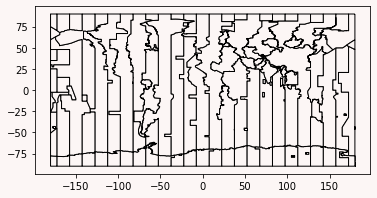

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
ax.set_facecolor('#FCF6F5FF')
data.plot(ax=ax, color='#FCF6F5FF', edgecolor='black', lw=1)
plt.show()

### Exercise

- Reproject the data map.
- Find a colourmap that highlights the different timezones clearly.
- Plot the worlds borders on top to show how timezones match with country outlines.

<img src="../resources/assets/timezones.png"  width="500" height="500">

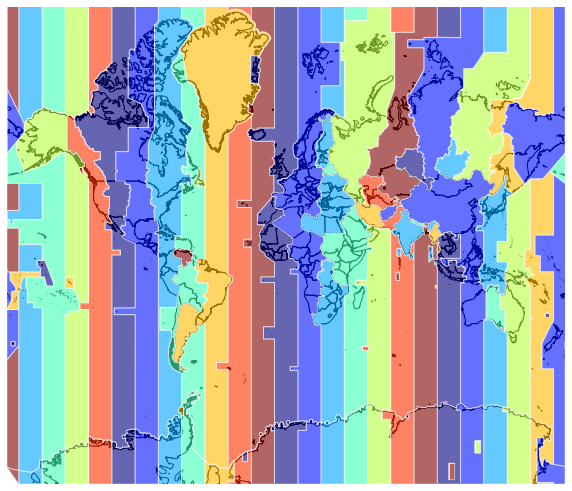

In [3]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()}, 
                       figsize=(10,10))

countries.plot(ax=ax, 
               transform=ccrs.PlateCarree(), 
               color='none', 
               edgecolor='black', 
               lw=1)
data.plot(ax=ax, 
          transform=ccrs.PlateCarree(), 
          column='map_color8', 
          cmap='jet', 
          edgecolor='white', 
          lw=1, 
          alpha=0.6)
ax.axis('off')
plt.show()

## Exercise

- Read the roman_empire.geojson and mongol_empire.geojson from the resources folder
- Generate a plot showing both empires
- Isolate the overlap between the two

<img src="../resources/assets/rome_example.png"  width="500" height="500">

![alt text](../resources/assets/overlay_operations.png "Title")


In [4]:
roman_empire = gpd.read_file("../resources/roman_empire.geojson")
mongol_empire = gpd.read_file("../resources/mongol_empire.geojson")

In [5]:
overlap = roman_empire.overlay(mongol_empire, how='intersection')

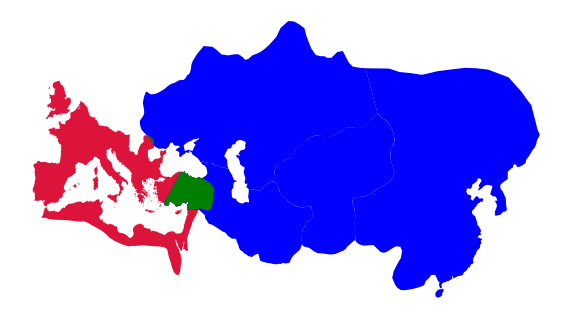

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()}, 
                       figsize=(10,10))

roman_empire.plot(ax=ax, 
                  transform=ccrs.PlateCarree(), 
                  color='crimson')
mongol_empire.plot(ax=ax, 
                   transform=ccrs.PlateCarree(), 
                   color='blue')
overlap.plot(ax=ax, 
             transform=ccrs.PlateCarree(), 
             color='green')
ax.axis('off')
plt.show()

### Combining Polygons, LineStrings and Points

In this section we will generate a map of all flights that take place between this timezone (Texas) and my timezone (UK)

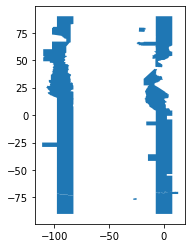

In [7]:
import pandas as pd

uk = data.loc[data['name'] == '0']
texas = data.loc[data['name'] == '-6']
my_flight = pd.concat([uk, texas])
my_flight.plot()
plt.show()

In [8]:
airports = pd.read_csv("../resources/airports", 
                       delimiter=',', 
                       names=['id', 'name', 'city', 'country', 'iata', 
                              'icao', 'lat', 'long', 'altitude', 'timezone',
                              'dst', 'tz', 'type', 'source'])

In [9]:
routes = pd.read_csv("../resources/routes",
                     delimiter=',', 
                     names=['airline', 'id', 'source_airport', 'source_airport_id',
                            'destination_airport', 'destination_airport_id', 'codeshare',
                            'stops', 'equitment'])

In [10]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(airports['long'], airports['lat'])]
airports = gpd.GeoDataFrame(airports, crs="EPSG:4326", geometry=geometry)

In [11]:
new_airports = gpd.sjoin(airports, my_flight, predicate='within')

In [12]:
print(new_airports.columns)

Index(['id', 'name_left', 'city', 'country', 'iata', 'icao', 'lat', 'long',
       'altitude', 'timezone', 'dst', 'tz', 'type', 'source', 'geometry',
       'index_right', 'objectid', 'scalerank', 'featurecla', 'name_right',
       'map_color6', 'map_color8', 'note', 'zone', 'utc_format', 'time_zone',
       'iso_8601', 'places', 'dst_places', 'tz_name1st', 'tz_namesum'],
      dtype='object')


In [13]:
new_airports = new_airports.rename(columns = {'name_left': 'airport_name', 'name_right': 'timezone_name'})

In [14]:
print(new_airports.airport_name.unique())
print(new_airports.timezone_name.unique())

['Akureyri Airport' 'Egilsstaðir Airport' 'Hornafjörður Airport' ...
 'Aerodromo de Castelo Branco' 'Ponte de Sor Airport'
 'Vilar de Luz Airfield']
['0' '-6']


In [15]:
from shapely.geometry import LineString

source_airports = new_airports[['airport_name', 'iata', 'icao', 
                                'lat', 'long', 'timezone_name']]
destination_airports = source_airports.copy()
source_airports.columns = [str(col) + '_source' for col in source_airports.columns]
destination_airports.columns = [str(col) + '_destination' for col in destination_airports.columns]

routes = routes[['source_airport', 'destination_airport']]

routes = pd.merge(routes, 
                  source_airports, 
                  left_on='source_airport', 
                  right_on='iata_source')
routes = pd.merge(routes, 
                  destination_airports, 
                  left_on='destination_airport', 
                  right_on='iata_destination')

In [16]:
print(routes)

     source_airport destination_airport        airport_name_source  \
0               ABJ                 BOY         Port Bouet Airport   
1               OUA                 BOY        Ouagadougou Airport   
2               ABJ                 OUA         Port Bouet Airport   
3               ABJ                 OUA         Port Bouet Airport   
4               ABJ                 OUA         Port Bouet Airport   
...             ...                 ...                        ...   
3674            YHP                 YNO        Poplar Hill Airport   
3675            YPM                 YNO         Pikangikum Airport   
3676            YNO                 YHP  North Spirit Lake Airport   
3677            YPM                 YHP         Pikangikum Airport   
3678            ZSJ                 KEW         Sandy Lake Airport   

     iata_source icao_source  lat_source  long_source timezone_name_source  \
0            ABJ        DIAP    5.261390    -3.926290                    0   
1  

In [17]:
routes = routes[routes['timezone_name_source'] != routes['timezone_name_destination']]

routes_geometry = [LineString([[routes.iloc[i]['long_source'], 
                                routes.iloc[i]['lat_source']], 
                               [routes.iloc[i]['long_destination'], 
                                routes.iloc[i]['lat_destination']]]) for i in range(routes.shape[0])]
routes_geodata = gpd.GeoDataFrame(routes, geometry=routes_geometry, crs='EPSG:4326')

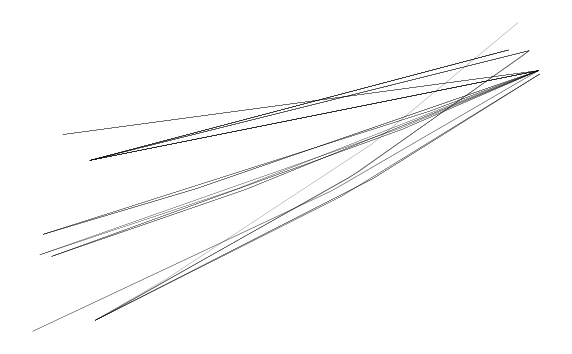

In [18]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()}, 
                       figsize=(10,10))

ax.patch.set_facecolor('#FCF6F5FF')
routes_geodata.plot(ax=ax, 
                    transform=ccrs.PlateCarree(), 
                    color='black', 
                    linewidth=0.1)
ax.axis('off')
plt.show()

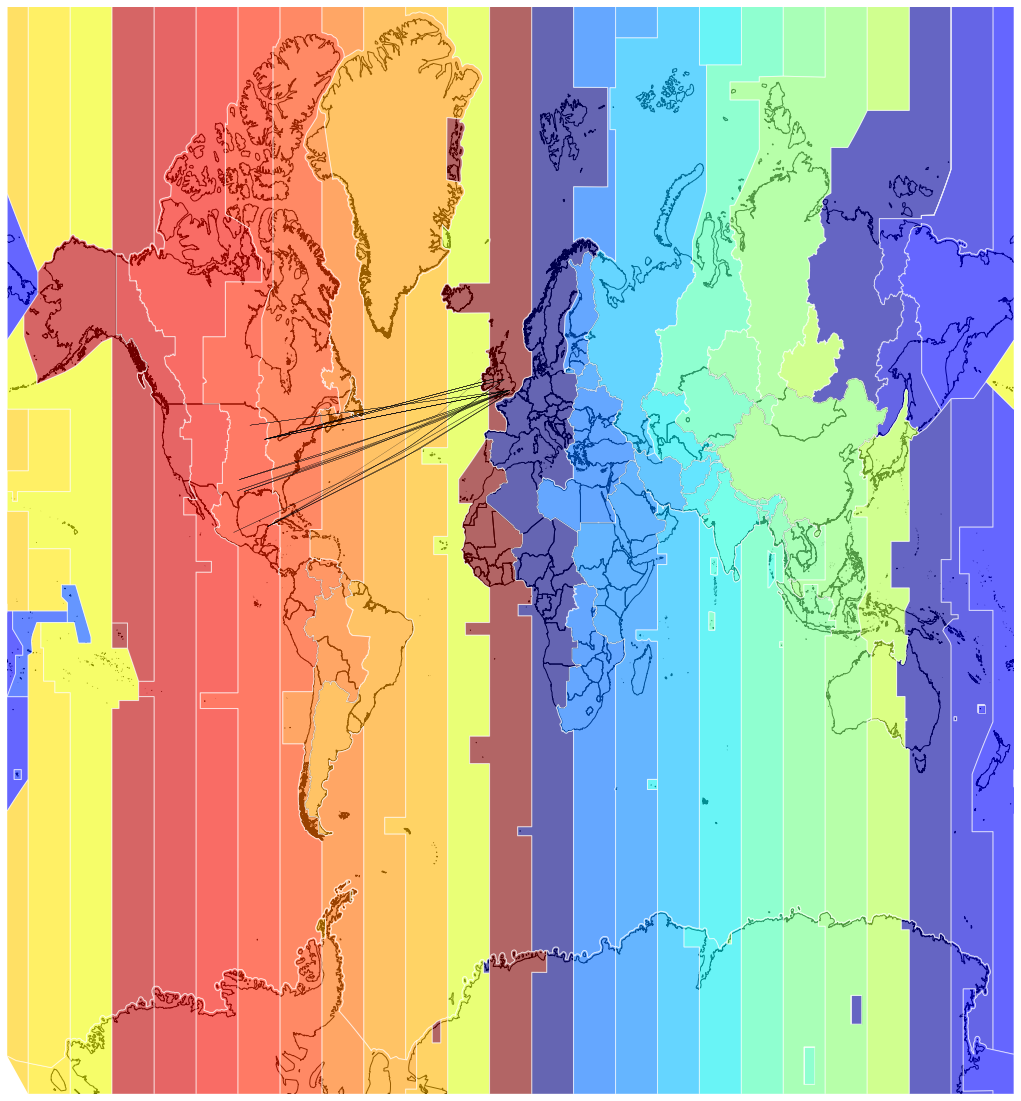

In [19]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()}, 
                       figsize=(20,20))

countries.plot(ax=ax, transform=ccrs.PlateCarree(), 
               color='none', 
               edgecolor='black', 
               lw=1)
data.plot(ax=ax, 
          transform=ccrs.PlateCarree(), 
          column='name', 
          cmap='jet', 
          edgecolor='white', 
          lw=1, 
          alpha=0.6)
routes_geodata.plot(ax=ax, 
                    transform=ccrs.PlateCarree(), 
                    color='black', 
                    linewidth=0.1)
ax.axis('off')
plt.show()

## Exercise

- Show the airports as well as the flight routes.
- Clip the image to only show the area where flights occur.
- Account for the curvature of the earth in your line projection.

In [20]:
print(new_airports.columns)
print(routes.columns)

Index(['id', 'airport_name', 'city', 'country', 'iata', 'icao', 'lat', 'long',
       'altitude', 'timezone', 'dst', 'tz', 'type', 'source', 'geometry',
       'index_right', 'objectid', 'scalerank', 'featurecla', 'timezone_name',
       'map_color6', 'map_color8', 'note', 'zone', 'utc_format', 'time_zone',
       'iso_8601', 'places', 'dst_places', 'tz_name1st', 'tz_namesum'],
      dtype='object')
Index(['source_airport', 'destination_airport', 'airport_name_source',
       'iata_source', 'icao_source', 'lat_source', 'long_source',
       'timezone_name_source', 'airport_name_destination', 'iata_destination',
       'icao_destination', 'lat_destination', 'long_destination',
       'timezone_name_destination', 'geometry'],
      dtype='object')


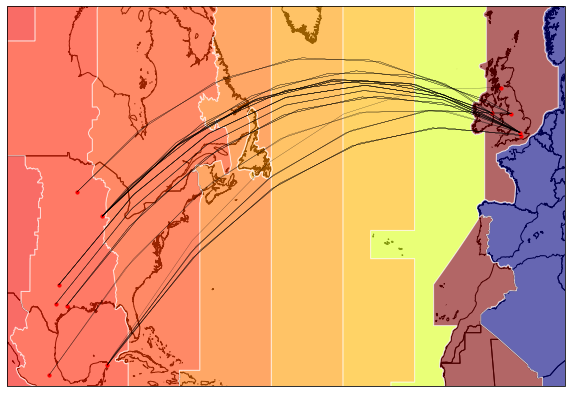

In [21]:
new_airports = new_airports.loc[new_airports['iata'].isin(routes.iata_source.unique().tolist() + routes.iata_destination.unique().tolist())]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()}, 
                       figsize=(10,10))
countries.plot(ax=ax, 
               transform=ccrs.PlateCarree(), 
               color='none', 
               edgecolor='black', 
               lw=1)
data.plot(ax=ax, 
          transform=ccrs.PlateCarree(), 
          column='name', 
          cmap='jet', 
          edgecolor='white', 
          lw=1, 
          alpha=0.6)
routes_geodata.plot(ax=ax, 
                    transform=ccrs.Geodetic(), 
                    color='black', 
                    linewidth=0.1)
new_airports.plot(ax=ax, 
                  transform=ccrs.PlateCarree(), 
                  color="red", 
                  markersize=10)

ax.set_ylim(2000000, 9000000)
ax.set_xlim(-12000000, 1000000)
plt.show()